# Peakfinder + nDSM Generator (DSM − DGM1 / Bavaria)

This notebook downloads a **DTM (DGM1)** from Bavarias INSPIRE **WCS 2.0.1**, clips it to your DSMs AOI, **aligns** it to the DSM grid, and computes an **nDSM = DSM − DTM**.

---

#### What you’ll need
- A **DSM GeoTIFF** (any CRS; will be handled).
- **Credentials** for the Bavarian WCS (LDBV).
- Packages: `requests`, `rasterio`, `shapely`, `numpy`.

> **Data source & license:** DGM1 — *Bayerische Vermessungsverwaltung* (LDBV), **CC BY 4.0**. Bitte die Quelle in Ergebnissen angeben.

---

#### How it works (pipeline)
1. Read DSM extent → transform to **EPSG:25832** → apply small buffer.
2. WCS 2.0.1 **GetCoverage** for `EL.ElevationGridCoverage` with that AOI.
3. **Align** DTM to the DSM’s pixel grid (CRS, transform, dimensions).
4. Compute **nDSM = DSM − aligned DTM**.
5. extract heights from nDSM

---

#### Credentials (recommended: env vars)
Set once in your conda env so you don’t type them each time.

**Anaconda:**
```bash
conda activate peakfinder
conda env config vars set LDBV_USER="your_user" LDBV_PASS="your_password"
conda deactivate && conda activate nDSM_generator

In [1]:
import sys
from pathlib import Path
import rasterio
import pyodbc
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, getpass

project_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(project_root))

from peakfinder.modules.field_data import *
from peakfinder.modules.merge import *
from peakfinder.modules.segmentation import * 
from peakfinder.modules.ndsm_tools import *
from peakfinder.modules.tree_tops import *


In [2]:
# === USER INPUTS ===
dsm = r"D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_DSM.tif"
dtm = r"D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_DTM.tif" #if DTM is required
ndsm = r"D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_nDSM.tif"  # "" to skip nDSM

BUFFER_M = 2.0   # 0..2 m is fine for most use cases
PIXEL_M  = 1.0   # DGM1 native spacing (m)

# === Credentials ===
USER = os.getenv("LDBV_USER") or input("LDBV username: ")
PWD  = os.getenv("LDBV_PASS") or getpass.getpass("LDBV password: ")

LDBV username:  test
LDBV password:  ········


In [15]:
ndsm_arg = ndsm if ndsm else None
aligned_dtm, ndsm = run_pipeline(
    dsm_path=dsm,
    dtm_save_path=dtm,
    ndsm_save_path=ndsm_arg,
    buffer_m=BUFFER_M,
    pixel_m=PIXEL_M,
    user=USER,
    password=PWD,
    allow_prompt=False  # we already supplied creds above
)
print("Aligned DTM:", aligned_dtm)
print("nDSM:", ndsm)


[1/4] Computing AOI from DSM (EPSG:25832)…
      AOI: 720013.663, 5334706.949, 720579.804, 5335350.508 (buffer 2.0 m)
[2/4] Downloading DGM1 via WCS 2.0.1…
      Saved DTM: D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_DTM.tif
[3/4] Aligning DTM to DSM grid…
[4/4] Computing nDSM = DSM − DTM…
      Saved nDSM: D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_nDSM.tif
Aligned DTM: D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_DTM_aligned_to_DSM.tif
nDSM: D:\Drohnendaten\19_W007\Ecke_Baumhöhen\TEMP\EBE_151_20240925_nDSM.tif


# Part 1: Simple tree top detection

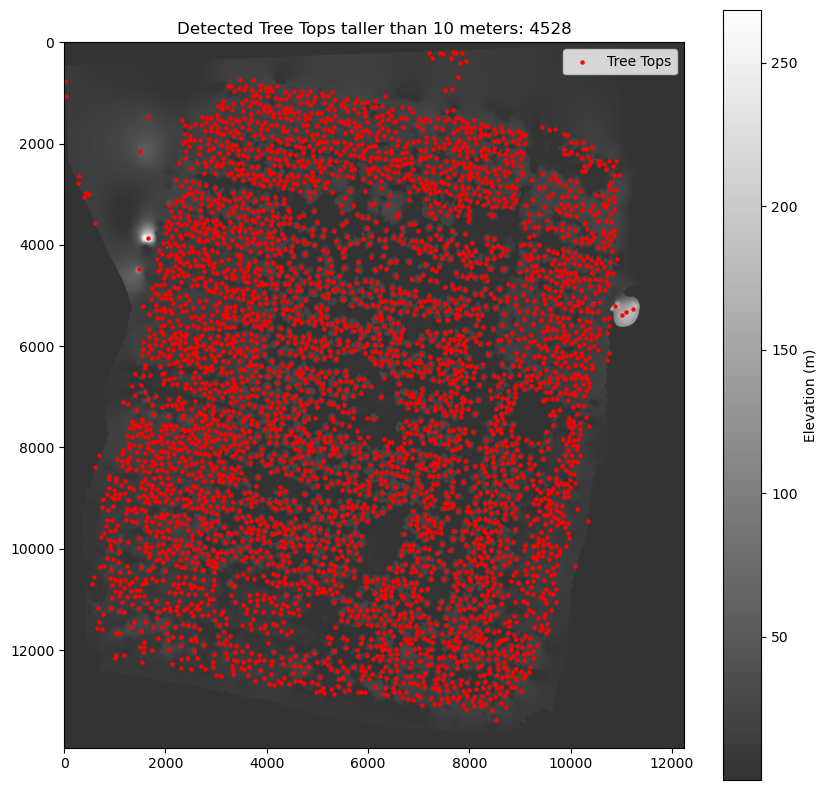

In [3]:
tree_top_values, fig, ax = detect_tree_tops(ndsm, neighborhood_size=100, min_height_threshold=10, sigma=2)

In [17]:
# Convert to DataFrame
#df = pd.DataFrame(tree_top_values, columns=["utm_x", "utm_y", "tree_height"])

# Save as CSV
#df.to_csv(r"C:\Users\lwfeckesim\Desktop\bernhard_uav_height\tree_tops.csv", index=False)


#### Check database connection

In [4]:
dsn_name = "ecke"  # Replace with your DSN name

try:
    conn = pyodbc.connect(f"DSN={dsn_name};")
    print("Connected to the database successfully.")

    with conn.cursor() as cursor:
        query = """
        SELECT * FROM dbo.Objekte
        WHERE Versuch = ?
        AND Parzelle = ?
        """
        cursor.execute(query, (151, 1))

        # Fetch column names
        column_names = [column[0] for column in cursor.description]
        print("Column Names:")
        print(", ".join(column_names))  # Print column names once

        # Fetch all results
        results = cursor.fetchall()

        # Print each row of data
        print("\nData:")
        for row in results:
            print(row)

    print("Connection closed.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the database successfully.
Column Names:
Versuch, Parzelle, ObjektTyp, Nr, Artcode, OriginalNummer, x, y, z, xOriginal, yOriginal, zOriginal, Einmessung, IndexOderMetrisch, RasterGroesse, RadiusProbeKreis, ReihenNummer, Gruppe, xcrewho, xcrewhen, xlogwho, xlogwhen, UTM_x, UTM_y, UTM_z, Genauigkeit

Data:
(151, 1, 'Baum', 1, 70, None, 1.0, 0.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None, None, None, 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), None, None, None, None)
(151, 1, 'Baum', 2, 70, None, 1.0, 1.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None, None, None, 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), 'ADS\\ge73yos', datetime.datetime(2022, 1, 21, 14, 30, 37, 317000), None, None, None, None)
(151, 1, 'Baum', 3, 70, None, 1.0, 2.5, None, None, None, None, 'Errechnet aus Pflanzverband', None, None, None

In [5]:
dsns = pyodbc.dataSources()   # {DSN_name: driver_name}
print(dsns)

dsn_name = "ecke"
print("Exists:", dsn_name in dsns)
print("Driver:", dsns.get(dsn_name))

{'ecke': 'SQL Server'}
Exists: True
Driver: SQL Server


In [6]:
dsn_name = "ecke"
conn = pyodbc.connect(f"DSN={dsn_name};", timeout=5)
cur = conn.cursor()
#cur.execute("SELECT version();")
#print(cur.fetchone()[0])
conn.close()


In [7]:
dsn_name = "ecke"  # Replace with your DSN name
versuch_id = 151   # Specify the Versuch ID

corners, trees = fetch_corners_and_trees(dsn_name, versuch_id)

Connected to the database successfully.
Data retrieved successfully.
Corner points retrieved: 144
Tree points retrieved: 1547


#### Calculate stem coordinates from local coordinate system

In [8]:
# Find ground lines for all Plots
ground_lines = find_ground_lines(corners)

In [9]:
# Compute the ground vector and perpendicular vector for all plots ("Parzellen")
ground_vectors = {}
perpendicular_vectors = {}

for parzelle, (utm_lower_left, utm_lower_right) in ground_lines.items():
    # Compute the ground vector for the current Parzelle
    ground_vector = np.array([utm_lower_right[0] - utm_lower_left[0], utm_lower_right[1] - utm_lower_left[1]])
    ground_length = np.linalg.norm(ground_vector)
    unit_ground_vector = ground_vector / ground_length

    # Compute the perpendicular vector for the current Parzelle
    perpendicular_vector = np.array([-unit_ground_vector[1], unit_ground_vector[0]])

    # Store the results in dictionaries
    ground_vectors[parzelle] = unit_ground_vector
    perpendicular_vectors[parzelle] = perpendicular_vector


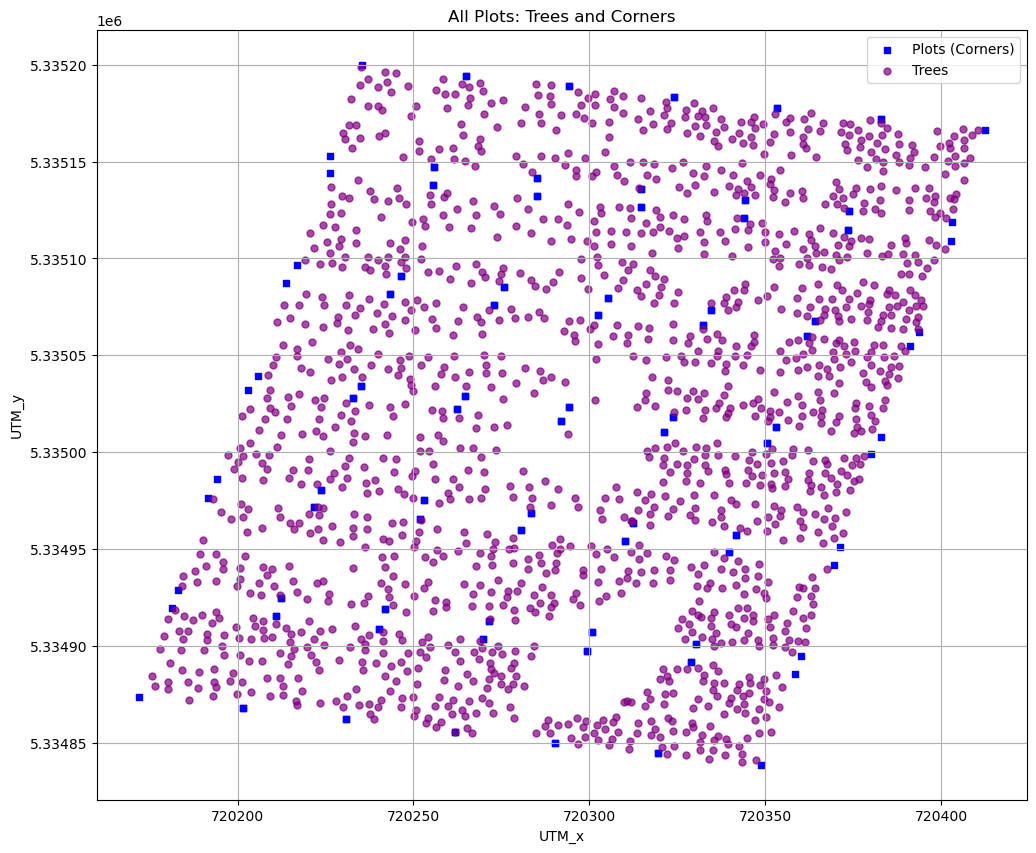

In [10]:
# Transform trees
transformed_trees = transform_trees_all(trees, ground_lines)

# Visualize all Parzellen
visualize_all_plots(corners, transformed_trees)


#### Simple matching of stem coordinates and tree top coordinates

In [11]:
# Perform the matching
matched_trees = match_stems_to_treetops(transformed_trees, tree_top_values, max_distance=2)

# Count matched and unmatched trees
matched_count = sum(1 for tree in matched_trees if tree[4] is not None)
unmatched_count = sum(1 for tree in matched_trees if tree[4] is None)

# Print the results
print(f"Matched trees: {matched_count}")
print(f"Unmatched trees: {unmatched_count}")


Matched trees: 932
Unmatched trees: 588


In [12]:
updated_matches = process_unmatched_stems(matched_trees, tree_top_values, radius=5)

# Count matched and unmatched trees
matched_count = sum(1 for tree in updated_matches if tree[4] is not None)
unmatched_count = sum(1 for tree in updated_matches if tree[4] is None)

# Print the results
print(f"Matched trees: {matched_count}")
print(f"Unmatched trees: {unmatched_count}")


Matched trees: 1031
Unmatched trees: 489


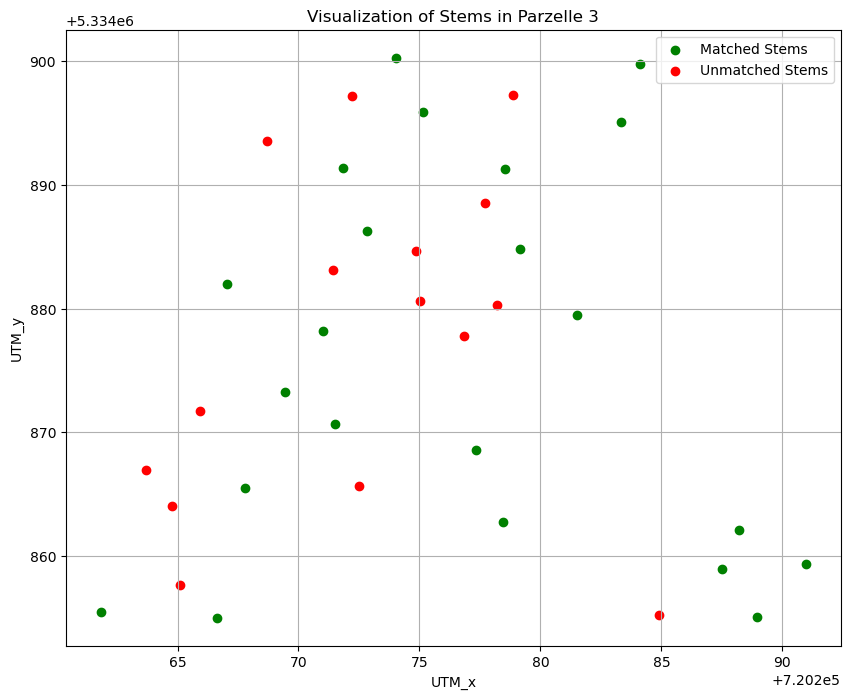

In [13]:
# Visualize individual plots
plot = 3
visualize_matched_trees(updated_matches, plot)  # Visualize for Parzelle 2

#### Visualize matched and unmatched trees

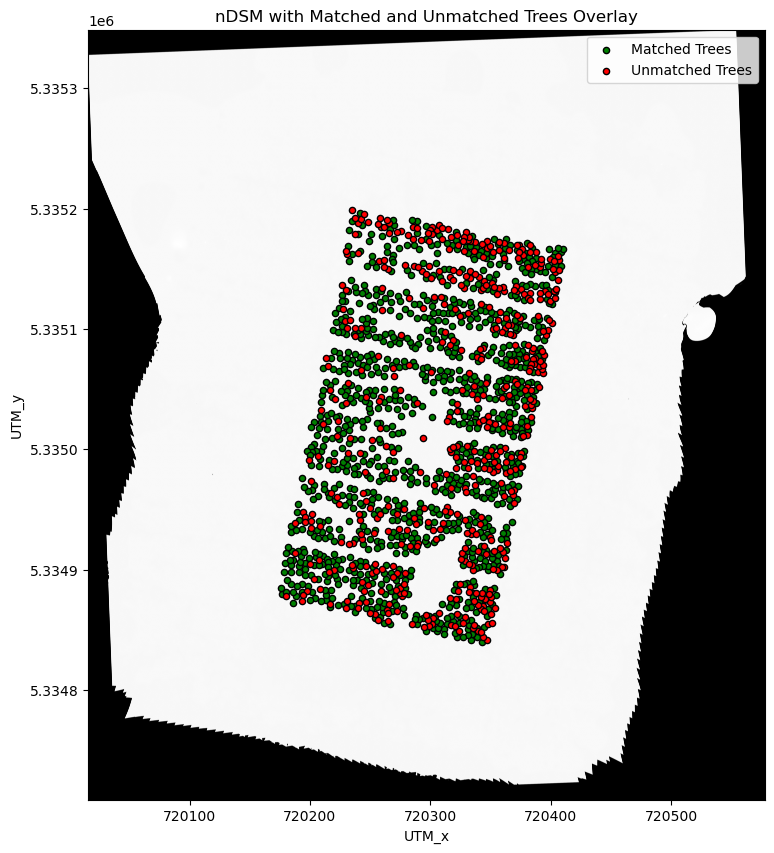

In [14]:
visualize_ndsm_with_trees(ndsm, updated_matches)

# Part 2: Sophisticated matching algorithm including marker-based watershed segmentation

#### Markerbased watershed segmentation (includes tree top detection)

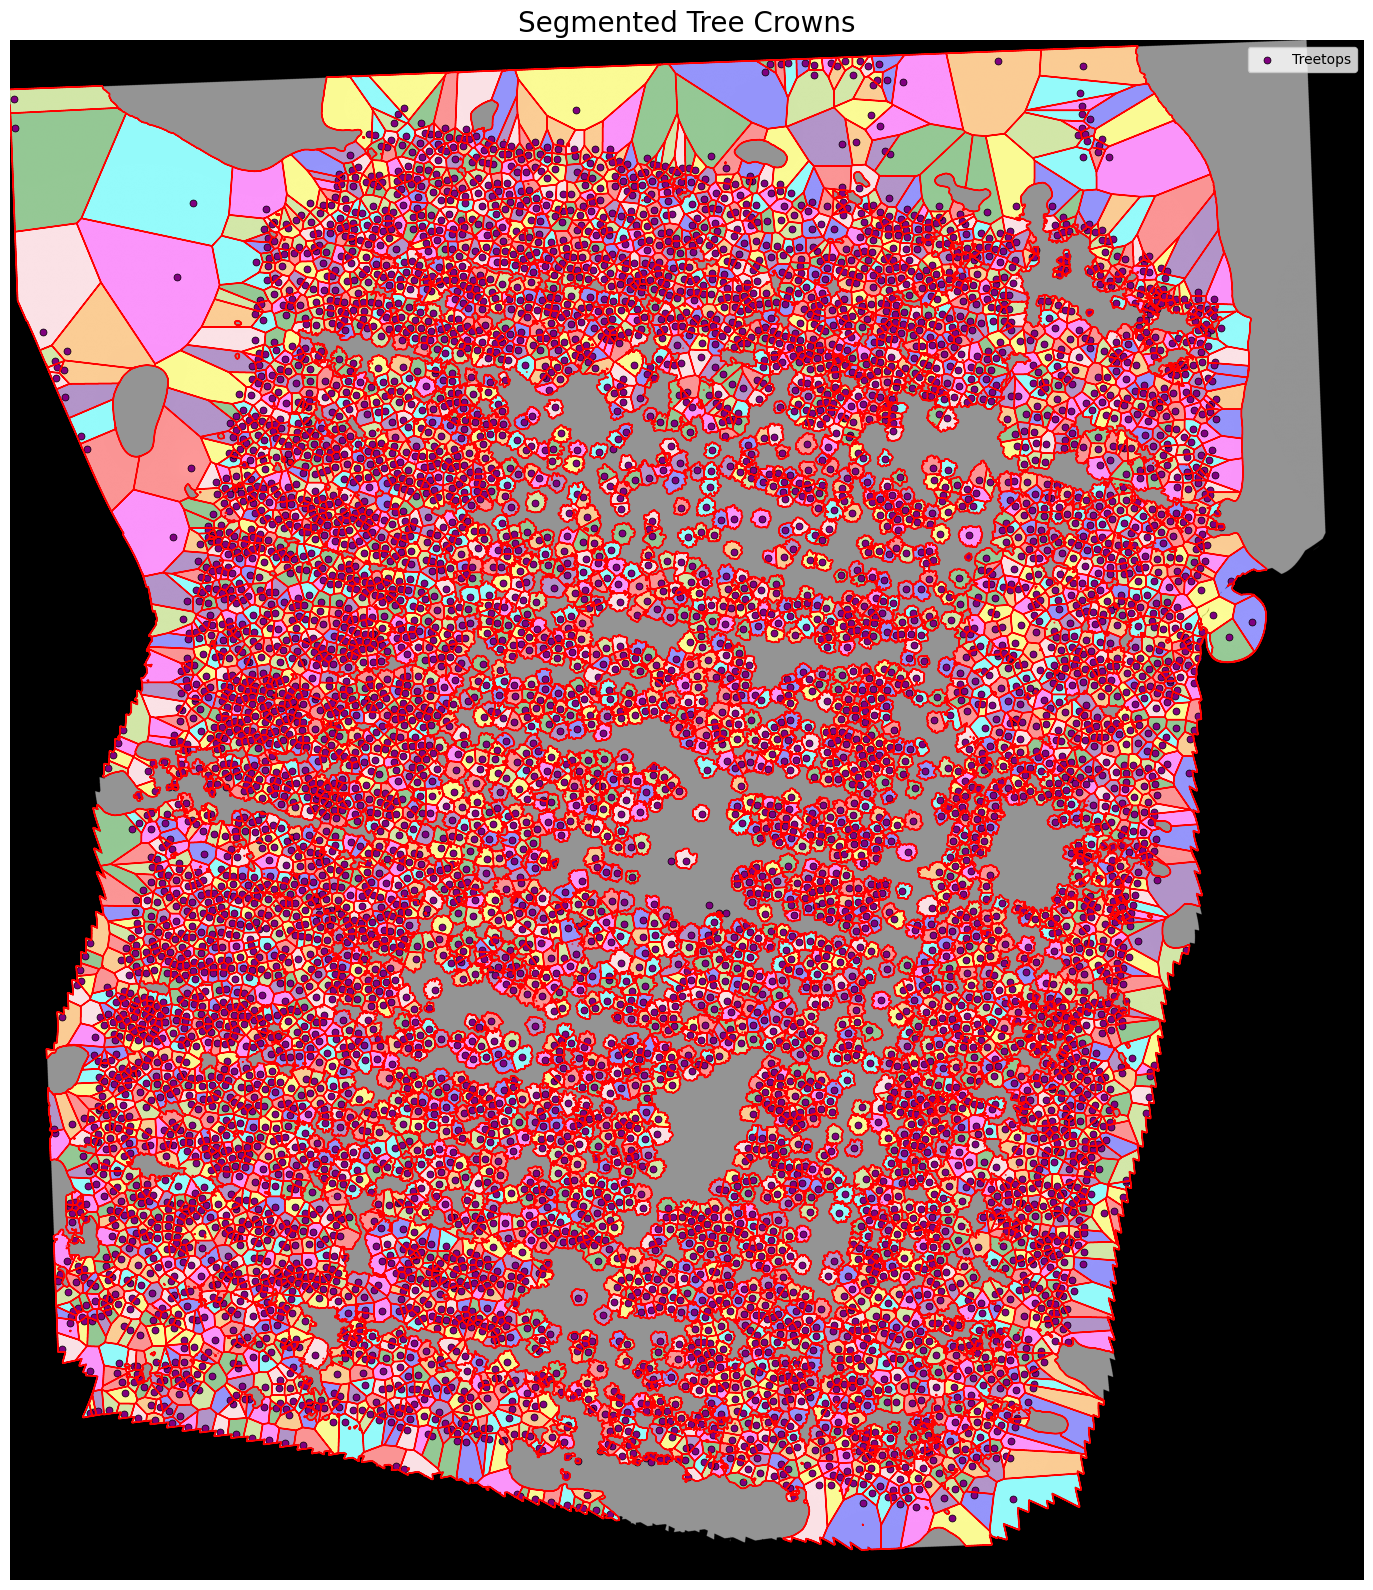

In [15]:
try:
    labels, treetop_coords, ndsm_subset, transform = segment_trees(
        ndsm_path=ndsm,
        ground_threshold=5,
        sigma_for_treetops=10.0,
        sigma_for_segmentation=1,
        min_distance=5,
        threshold_abs=5.0,
        exclude_border=True,
        connectivity=1,
        compactness=0.2,
        watershed_line=False,
        subset_size_meters=200,
        min_area_threshold=1500,
        use_subset=False,
        show_contours=True,
        return_arrays=True
    )
except Exception as e:
    print(f"An error occurred: {e}")


#### Match stems and tree tops within the same segment

#### All stems visualized

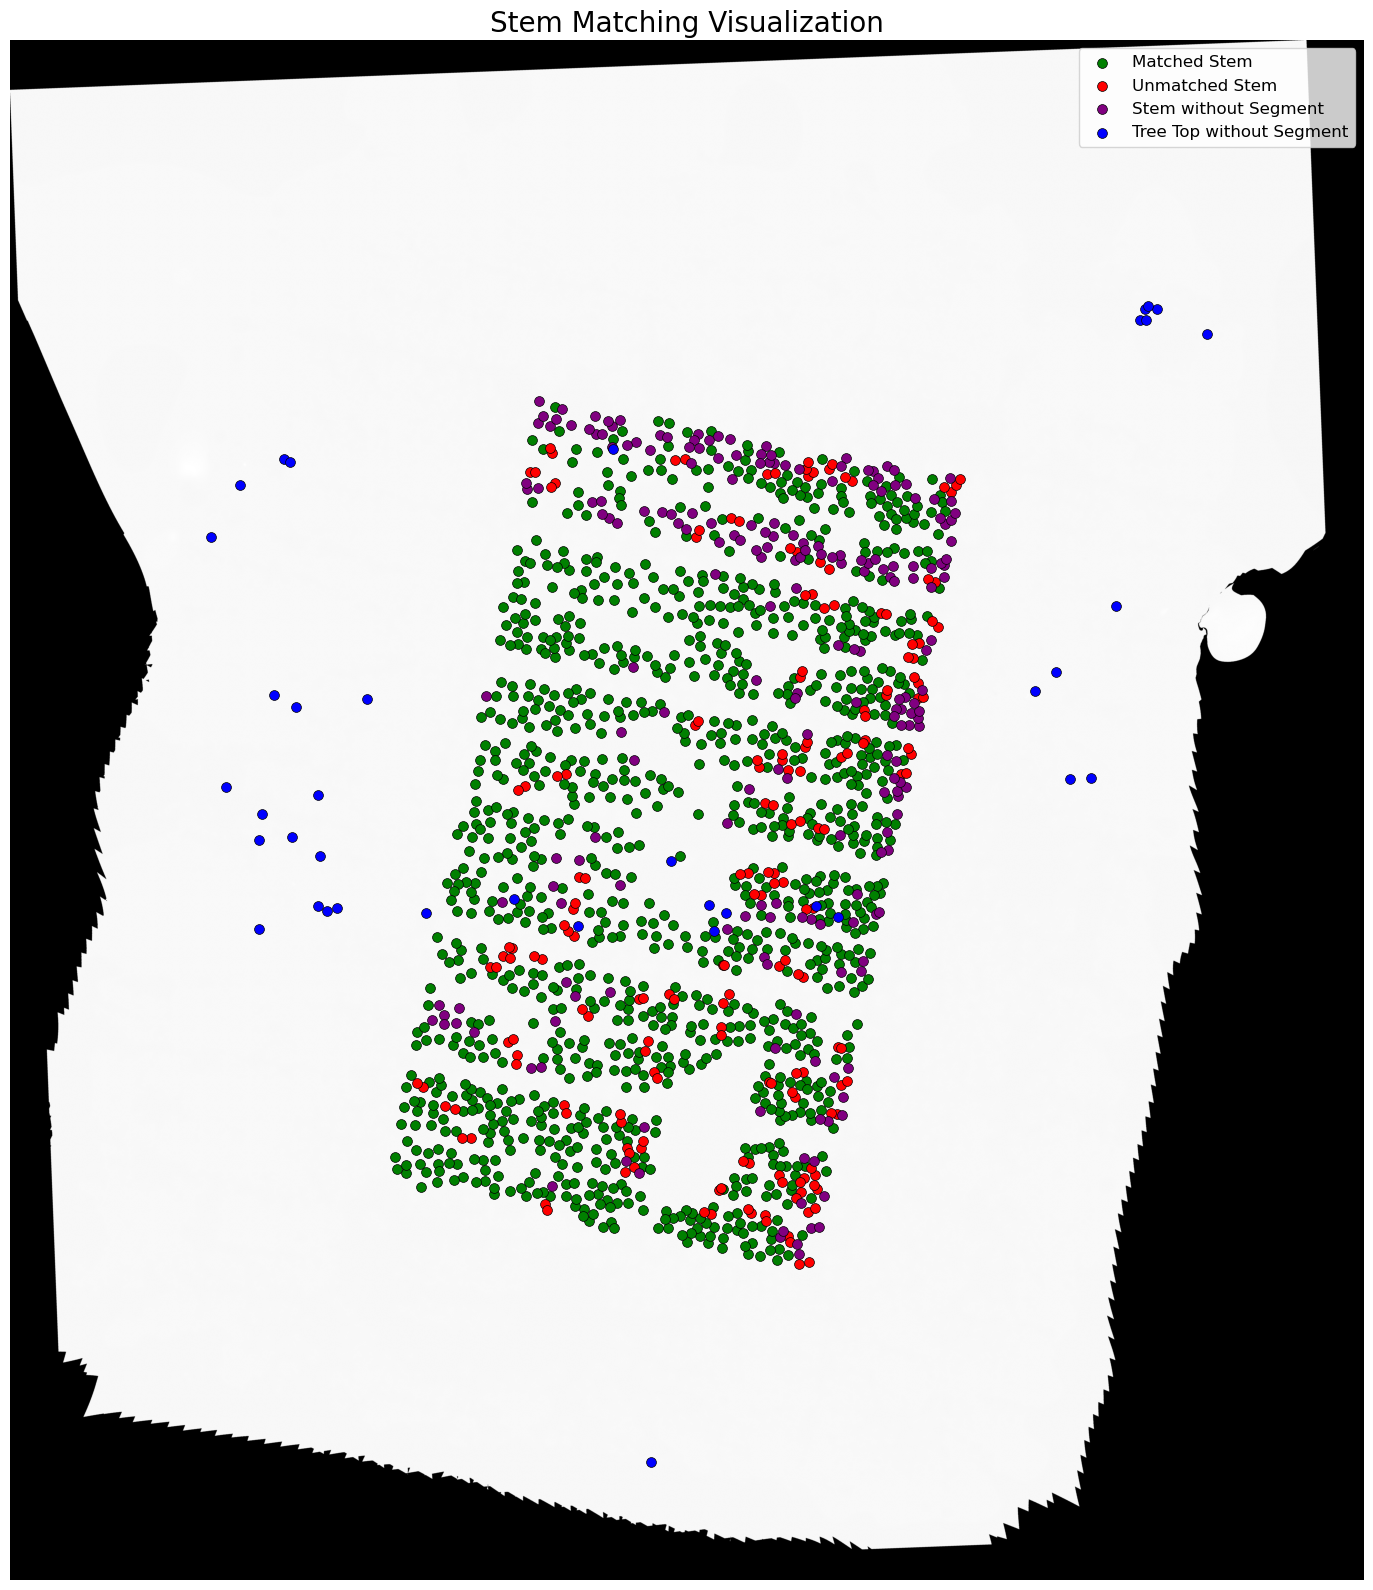

In [16]:

# Call the function
matched_stems = match_and_visualize_all(
    labels=labels,
    treetop_coords=treetop_coords,
    stem_coords=transformed_trees,
    ndsm=ndsm_subset,
    transform=transform
)

# Print matched stems
#for match in matched_stems:
    #print(match)


#### Tree height extracted from the highest pixel within the matched segment 

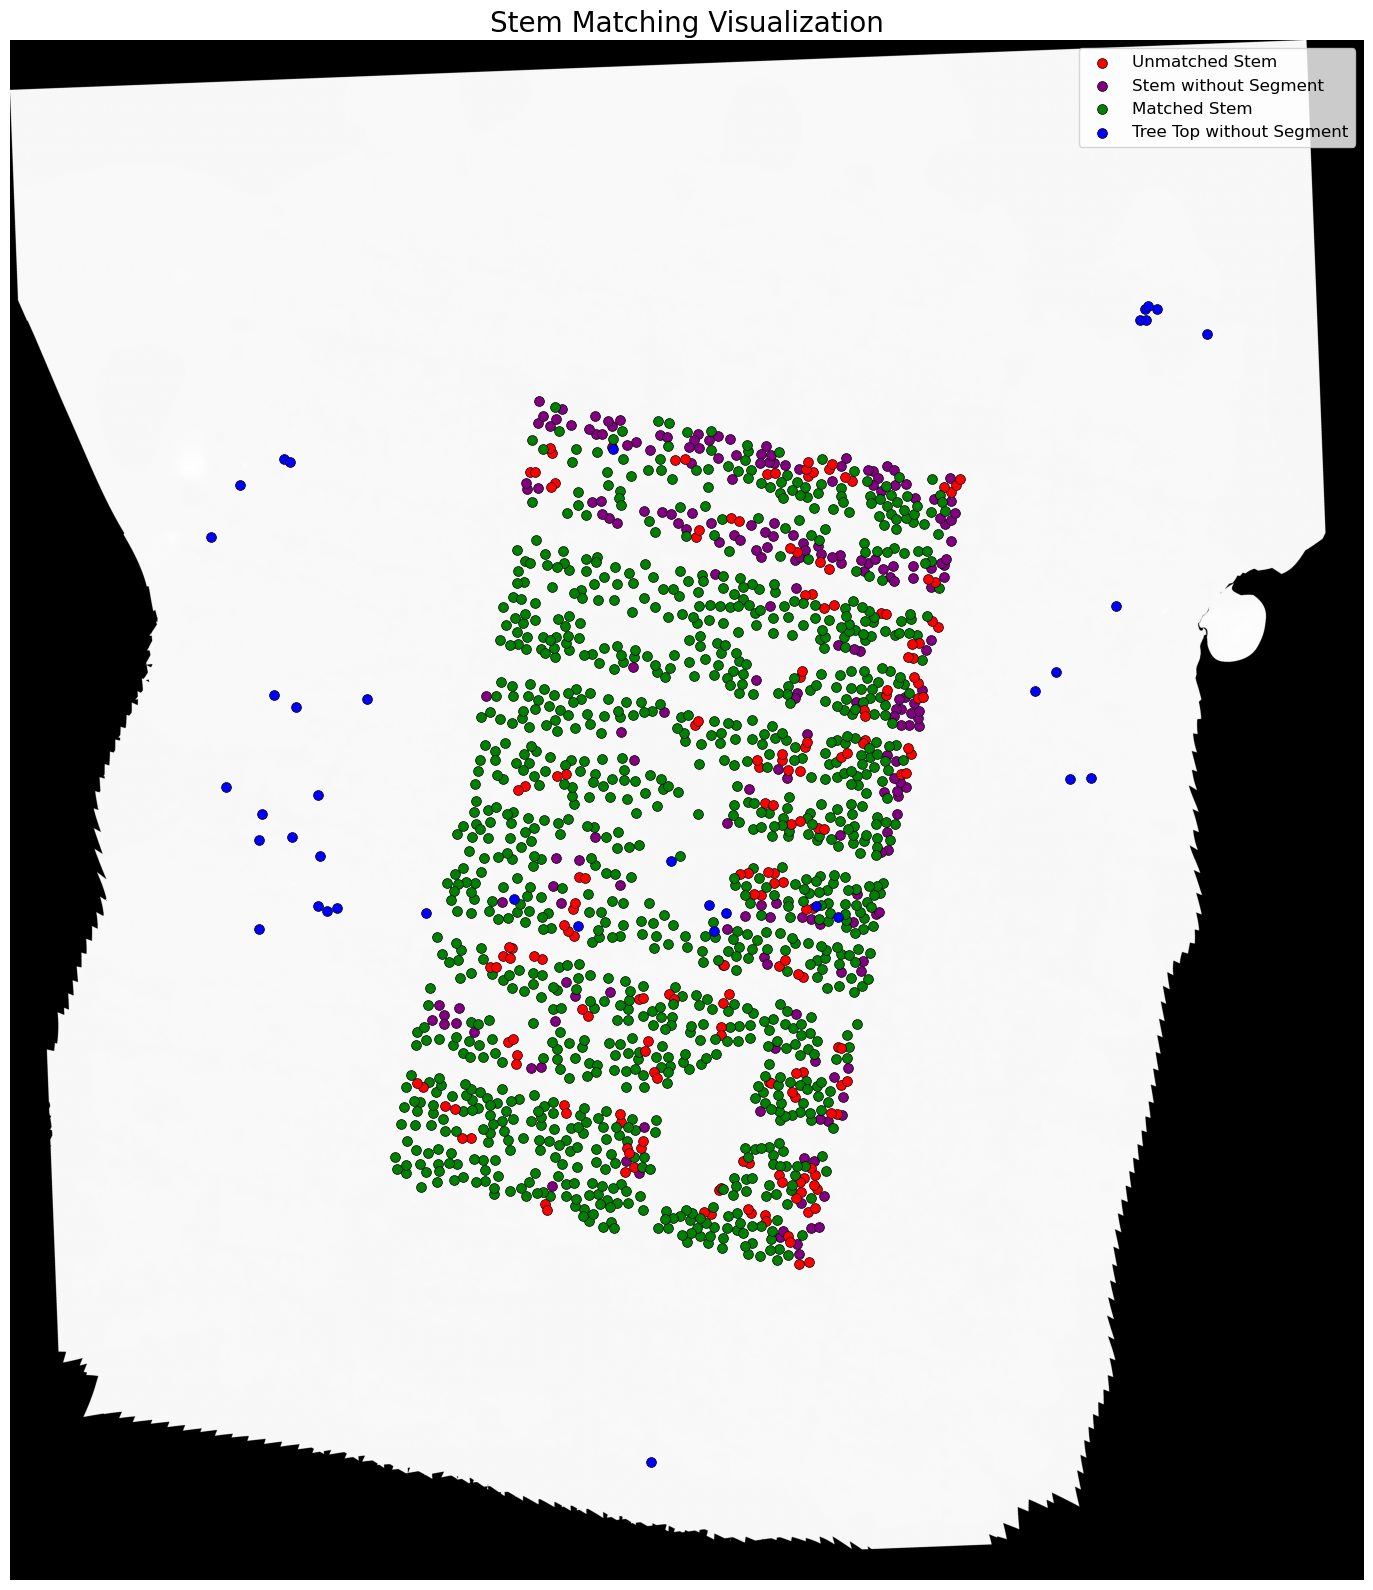

In [17]:
results = match_and_visualize_updated2(
    labels=labels,
    treetop_coords=treetop_coords,
    stem_coords=transformed_trees,
    ndsm=ndsm_subset,
    transform=transform
)

# Print results
#for result in results:
    #print(result)


#### Merge tables and export as .csv

In [30]:
valid_trees = [tree for tree in results if tree["UAV_Tree_Height_segment"] is not None]

if valid_trees:
    highest_tree = max(valid_trees, key=lambda x: x["UAV_Tree_Height_segment"])
    print("Highest Tree:")
    for key, value in highest_tree.items():
        print(f"{key}: {value}")
else:
    print("No valid trees with heights found.")


Highest Tree:
Parzelle: 18
Nr: 1007
Stem_UTM_X: 720227.6923134123
Stem_UTM_Y: 5335013.172683188
Treetop_UTM_X: 720228.0451774653
Treetop_UTM_Y: 5335011.359845788
UAV_Tree_Height_segment: 36.00543212890625
match: 1
UAV_Tree_Height_pixel: 30.99652099609375


In [18]:
# Sort results by "Parzelle" and then by "Nr"
results = sorted(results, key=lambda x: (x["Parzelle"], x["Nr"]))

In [23]:
# Merge results and matched_stems
merged_results = merge_dictionaries(results, matched_stems)

# Print merged results
#for item in merged_results:
#    print(item)


In [25]:
# Desired column order
column_order = [
    "Parzelle",
    "Nr",
    "Stem_UTM_X",
    "Stem_UTM_Y",
    "Treetop_UTM_X",
    "Treetop_UTM_Y",
    "UAV_Tree_Height_segment",
    "UAV_Tree_Height_pixel",
    "match",
]

# Reorder columns
reordered_data = [
    {col: item[col] for col in column_order if col in item} for item in merged_results
]

In [27]:


# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(reordered_data)

# Export to CSV
output_path = r"D:\Drohnendaten\19_W007\uav_tree_height.csv"
df.to_csv(output_path, index=False)

print(f"Data has been exported to {output_path}")


Data has been exported to D:\Drohnendaten\19_W007\uav_tree_height.csv


In [28]:
reordered_data

[{'Parzelle': 1,
  'Nr': 1001,
  'Stem_UTM_X': 720343.2284648679,
  'Stem_UTM_Y': 5334840.049333123,
  'Treetop_UTM_X': None,
  'Treetop_UTM_Y': None,
  'UAV_Tree_Height_segment': None,
  'UAV_Tree_Height_pixel': None,
  'match': 0},
 {'Parzelle': 1,
  'Nr': 1002,
  'Stem_UTM_X': 720347.4499555094,
  'Stem_UTM_Y': 5334841.227898039,
  'Treetop_UTM_X': None,
  'Treetop_UTM_Y': None,
  'UAV_Tree_Height_segment': None,
  'UAV_Tree_Height_pixel': None,
  'match': 0},
 {'Parzelle': 1,
  'Nr': 1003,
  'Stem_UTM_X': 720343.3257155236,
  'Stem_UTM_Y': 5334844.520411584,
  'Treetop_UTM_X': None,
  'Treetop_UTM_Y': None,
  'UAV_Tree_Height_segment': None,
  'UAV_Tree_Height_pixel': None,
  'match': 2},
 {'Parzelle': 1,
  'Nr': 1004,
  'Stem_UTM_X': 720344.7316728459,
  'Stem_UTM_Y': 5334852.398436965,
  'Treetop_UTM_X': 720345.0483182654,
  'Treetop_UTM_Y': 5334852.4780297885,
  'UAV_Tree_Height_segment': 27.107666,
  'UAV_Tree_Height_pixel': 27.106262,
  'match': 1},
 {'Parzelle': 1,
  'Nr': 10